# Estimating Seats-Votes Curves using a Moment-Matching approach

*Levi John Wolf<br>
University of Bristol<br>
levi.john.wolf@gmail.com<br>
(Supported by NSF #1657689)*

The moment-matching estimator provided by `seatsvotes` is conceptually similar to the `Bootstrapper` method. Thus, we'll consider the same full-congress dataset from 2006 and 2008 as that considered in the previous chapter. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seatsvotes

In [3]:
house = seatsvotes.data.congress(geo=True)
house = house.query('year in (2006,2008)')

In [4]:
house['district_id'] = house.contest_ui.apply(lambda x: x[3:])

For clarity, the `Bootstrapper` method
1. constructs the swing vector, $\delta = v_{t} - v_{t-1}$, 
2. shuffles the swings in $\delta$ to make $\tilde{\delta}$
3. finally applies $\tilde{\delta}$ to $v_{t-1}$ to build an alternative realization, $v_{t}'$. 

The `Reswing` method is conceptually similar; instead of shuffling or resampling $\delta$, the `Reswing` method samples from a kernel density estimate of the swing distribution. To illustrate, let's first let the class clean up the data:

In [9]:
reswing = seatsvotes.Reswing(house, 
                             uncontested='ignore',
                             district_id='district_id')

/home/lw17329/Dropbox/dissert/dev/seatsvotes/seatsvotes/utils.py:143: UserWarning: computing redistricting from years vector
  warn('computing redistricting from years vector')


The swing in 2008 can be grabbed from the last year's `wide`-form dataframe:

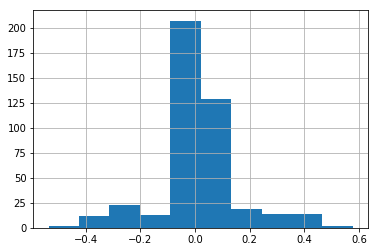

In [12]:
reswing.wide[-1].swing.hist()

Then, the `Reswing` class fits a kernel density estimate over this using `scipy`:

In [13]:
from scipy.stats import gaussian_kde

Then, with the kernel density estimator, the distribution is approximated:

In [15]:
kde = gaussian_kde(reswing.wide[-1].swing)

And `n_sims * n_districts` realizations from the KDE are drawn. 

In [17]:
swings = kde.resample(1000 * reswing.wide[-1].shape[0])

Since the KDE assumes observations are distributed independently and identically-distributed in the distribution, the sample has no notion of a single election; it's simply constructing `n_districts * n_sims` draws from the swing distribution, just like a Bootstrap with replacement. Therefore, we reshape the large & flat array of fake swings into *real* swings:

In [18]:
swings = swings.reshape(1000, -1)

Now, we can assess the "accuracy" of these swings by comparing the sampled versions to the observed swing distribution:

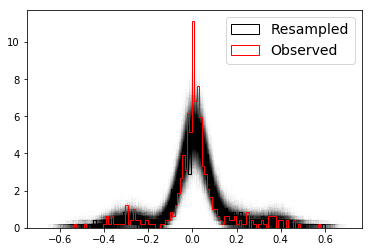

In [30]:
[plt.hist(swing, alpha=.01 if i != 0 else 1, color='k', bins=100, 
          histtype='step', density=True, label='Resampled' if i == 0 else None) for i,swing in enumerate(swings)]
plt.hist(kde.dataset.flatten(), color='r', bins=100, 
         histtype='step', density=True, label='Observed')
plt.legend(fontsize=14)
plt.show()

Then, the `Reswing` class uses these re-sampled swing vectors to construct alternative realizations of $v_t$. To see below, we'll show the resulting election distributions when we use the resampling method:

In [31]:
bootstrapped = bootstrapper.simulate_elections(n_sims=1000)

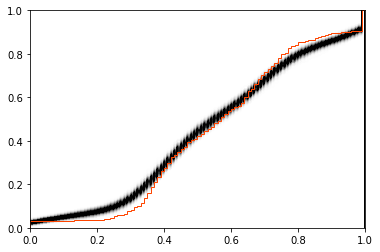

In [32]:
seatsvotes.plot.cdf_shroud(house.query('year == 2008').vote_share,
                           bootstrapped)

Like the bootstrap version, the KDE version overstates marginally-competitive Republican districts & marginally understates overcompetitive Democratic districts. In general, though, the curve mimicks the *slope* of the observed vote share distribution near the empirically-observed values, and also comes closest in that area. 